# Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
pd.set_option('display.max_columns', None)

# Import Data

In [ ]:
# 讀取資料
df = pd.read_csv('/content/train.csv')
# df = pd.read_csv('/kaggle/input/walmaa/test.csv')

# EDA!

- **TripType** - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.

- **VisitNumber** - an id corresponding to a single trip by a single customer

- **Weekday** - the weekday of the trip

- **Upc** - the UPC number of the product purchased

- **ScanCount** - the number of the given item that was purchased. A negative value indicates a product return.

- **DepartmentDescription** - a high-level description of the item's department

- **FinelineNumber** - a more refined category for each of the products, created by Walmart

There are 5704 duplicated entries

In [ ]:
df.loc[df.duplicated()].shape

(5704, 7)

Because every entries including ScanCount are duplicated, it is likely that the entries are really duplicates.

In [ ]:
df.loc[df.duplicated(keep=False)]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
55,42,19,Friday,7.675336e+09,1,IMPULSE MERCHANDISE,8904.0
59,42,19,Friday,7.675336e+09,1,IMPULSE MERCHANDISE,8904.0
134,26,61,Friday,7.535309e+09,1,HARDWARE,5525.0
135,26,61,Friday,7.535309e+09,1,HARDWARE,5525.0
460,8,225,Friday,4.093000e+03,1,PRODUCE,4008.0
...,...,...,...,...,...,...,...
646430,24,191177,Sunday,7.065200e+09,1,COOK AND DINE,905.0
646514,39,191190,Sunday,7.893138e+10,1,PETS AND SUPPLIES,6210.0
646525,39,191190,Sunday,7.893138e+10,1,PETS AND SUPPLIES,6210.0
646773,44,191277,Sunday,6.791453e+09,1,IMPULSE MERCHANDISE,347.0


Drop duplicates data

In [ ]:
df = df.drop_duplicates()

Let's look at the data shape

In [ ]:
df.shape

(641350, 7)

In [ ]:
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


## Explore the responses

There are 38 unique type of trip

In [ ]:
len(df['TripType'].unique())

38

The data is unbalanced, and there are 38! classes of data. Furthermore max-min number of members per class equal to ~170k members

<ipython-input-9-49d7e9854011>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sn.countplot(x = 'TripType', data = df, palette = 'mako')


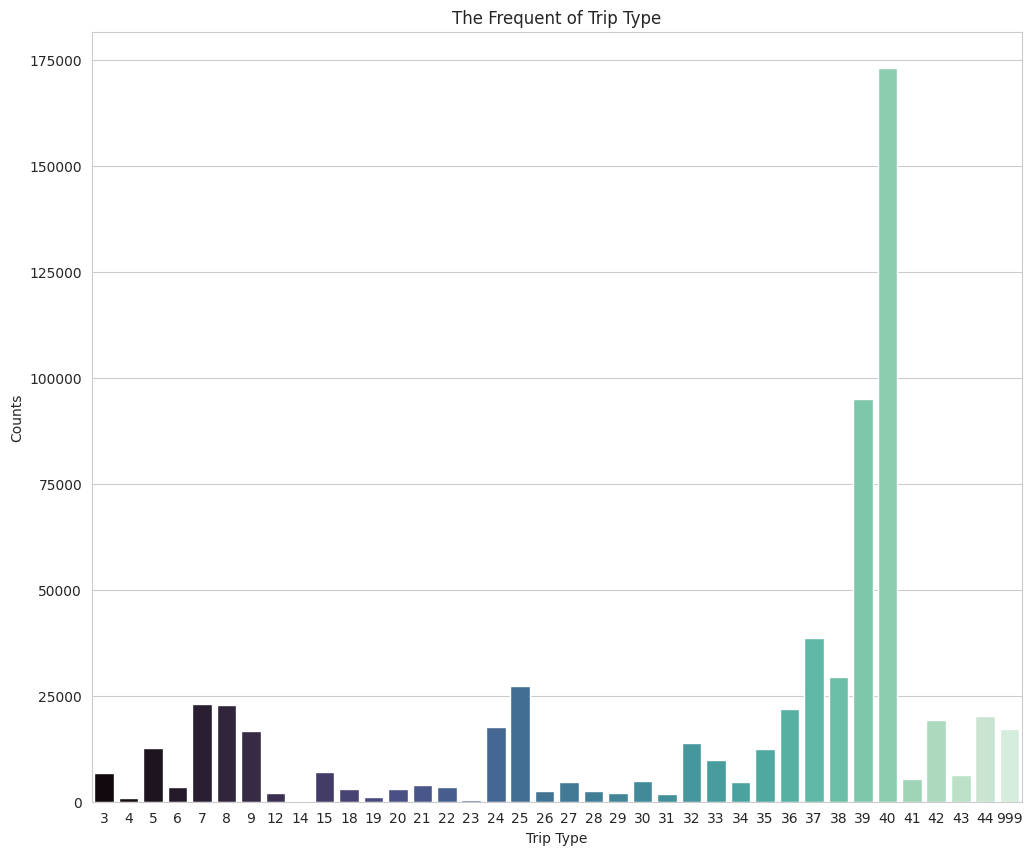

In [ ]:
plt.figure(figsize = (12, 10))

sn.set_style('whitegrid')
ax = sn.countplot(x = 'TripType', data = df, palette = 'mako')
ax = ax.set(title = 'The Frequent of Trip Type', ylabel = 'Counts', xlabel = 'Trip Type')

In [ ]:
df['TripType'].value_counts().describe()

,count
count,38.000000
mean,16877.631579
std,30921.087184
min,34.000000
25%,2983.250000
50%,6575.500000
75%,18912.500000
max,173031.000000


## Explore the predictors

### ScanCount

No null in scancount

In [ ]:
df.loc[df['ScanCount'].isnull()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber


Histrogram plot to see how the data distributed

<Axes: ylabel='Frequency'>

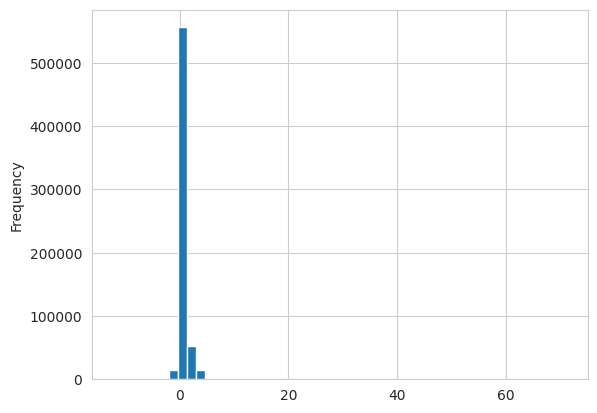

In [ ]:
df['ScanCount'].plot.hist(bins=50)

In [ ]:
df['ScanCount'].value_counts()


,count
ScanCount,
1,556283
2,52839
-1,14105
3,9421
4,4530
5,1378
6,865
-2,802
8,246


The biggest number of item purchase per item per visit seem to be 1 or 2 items

### Returned Item

The item that has been purchase and return in the same visit should be cut

In [ ]:
df.loc[df.duplicated(subset=['TripType', 'VisitNumber', 'Weekday', 'Upc', 'DepartmentDescription', 'FinelineNumber'], keep=False)]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
9,26,8,Friday,2.238400e+09,-1,PAINT AND ACCESSORIES,3565.0
11,26,8,Friday,8.867930e+10,2,PAINT AND ACCESSORIES,3504.0
14,26,8,Friday,8.867930e+10,-1,PAINT AND ACCESSORIES,3504.0
15,26,8,Friday,2.238400e+09,2,PAINT AND ACCESSORIES,3565.0
180,37,86,Friday,7.516665e+10,2,PRODUCE,7841.0
...,...,...,...,...,...,...,...
646845,40,191298,Sunday,6.811310e+10,1,BEAUTY,4541.0
646984,38,191337,Sunday,2.259120e+10,1,MEAT - FRESH & FROZEN,1301.0
646985,38,191337,Sunday,2.259120e+10,-1,MEAT - FRESH & FROZEN,1301.0
647004,38,191337,Sunday,2.261680e+10,-1,MEAT - FRESH & FROZEN,6405.0


In [ ]:
df = df.groupby(['Upc', 'TripType', 'VisitNumber', 'Weekday',
            'DepartmentDescription', 'FinelineNumber'])['ScanCount'].sum().reset_index()

In [ ]:
df.loc[df.duplicated(subset=['TripType', 'VisitNumber', 'Weekday',
                             'Upc', 'DepartmentDescription', 'FinelineNumber'], keep=False)]

,Upc,TripType,VisitNumber,Weekday,DepartmentDescription,FinelineNumber,ScanCount


In [ ]:
df = df.loc[df['ScanCount'] != 0]

The item that has been purchase and return in the same visit has been cut

In [ ]:
df['ScanCount'].value_counts()

,count
ScanCount,
1,548378
2,49714
3,9450
-1,7193
4,4887
5,1539
6,938
-2,280
8,277


The number of item purchase has not been change much

### VisitNumber

No null number

In [ ]:
df.loc[df['VisitNumber'].isnull()]

,Upc,TripType,VisitNumber,Weekday,DepartmentDescription,FinelineNumber,ScanCount


95674 unique visit numbers

In [ ]:
len(df['VisitNumber'].unique())

93086

In [ ]:
number_item_purchase = pd.DataFrame()

**Create a series counting number of unique item purchase per visit**

In [ ]:
number_item_purchase['unique_count'] = df.groupby(['VisitNumber'])['Upc'].count()

In [ ]:
number_item_purchase['unique_count'].head()

,unique_count
VisitNumber,
5,1
7,2
8,20
9,3
10,3


<Axes: ylabel='Frequency'>

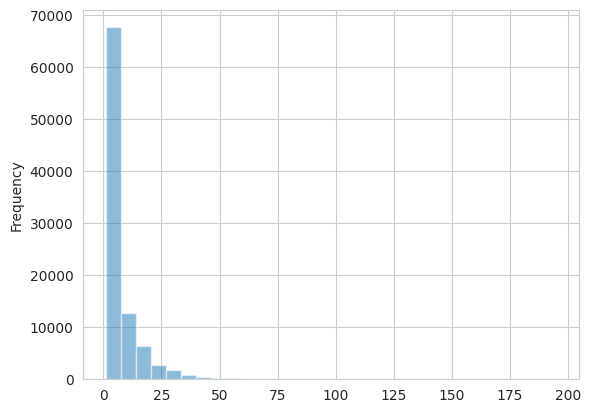

In [ ]:
number_item_purchase['unique_count'].plot.hist(bins=30, alpha=0.5)

In [ ]:
number_item_purchase['unique_count'].describe()

,unique_count
count,93086.000000
mean,6.697774
std,8.418281
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,195.000000


Unsurprisingly, walmart being a hypermarket average unique item is around 7 items sold per trip.

**Create a series counting number of items purchase per visit**

In [ ]:
number_item_purchase['item_sum'] = df.groupby(['VisitNumber'])['ScanCount'].sum()

In [ ]:
number_item_purchase['item_sum'].head()

,item_sum
VisitNumber,
5,-1
7,2
8,27
9,3
10,3


<Axes: ylabel='Frequency'>

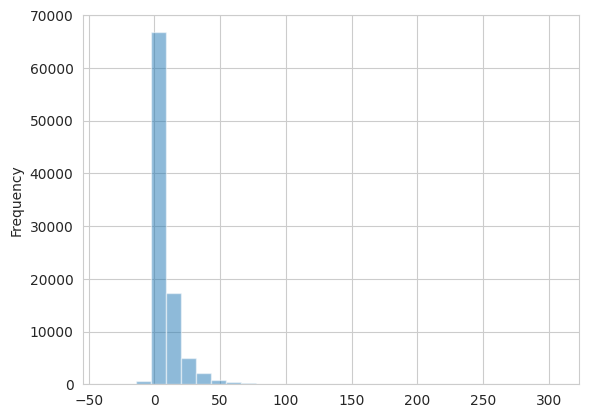

In [ ]:
number_item_purchase['item_sum'].plot.hist(bins=30, alpha=0.5)

In [ ]:
number_item_purchase['item_sum'].describe()

,item_sum
count,93086.000000
mean,7.623327
std,10.267037
min,-37.000000
25%,2.000000
50%,4.000000
75%,9.000000
max,306.000000


average sum items is around 8 items.

Add additional info to number_item_purchase for future uses

In [ ]:
number_item_purchase = number_item_purchase.reset_index().merge(df[['TripType', 'VisitNumber', 'Weekday']].drop_duplicates(), on='VisitNumber')
# number_item_purchase = number_item_purchase.reset_index().merge(df[['VisitNumber', 'Weekday']].drop_duplicates(), on='VisitNumber')

In [ ]:
number_item_purchase.shape

(93086, 5)

In [ ]:
number_item_purchase.head()

,VisitNumber,unique_count,item_sum,TripType,Weekday
0,5,1,-1,999,Friday
1,7,2,2,30,Friday
2,8,20,27,26,Friday
3,9,3,3,8,Friday
4,10,3,3,8,Friday


### Weekday

Let's look which day in week generate the most sale

<Axes: xlabel='Weekday'>

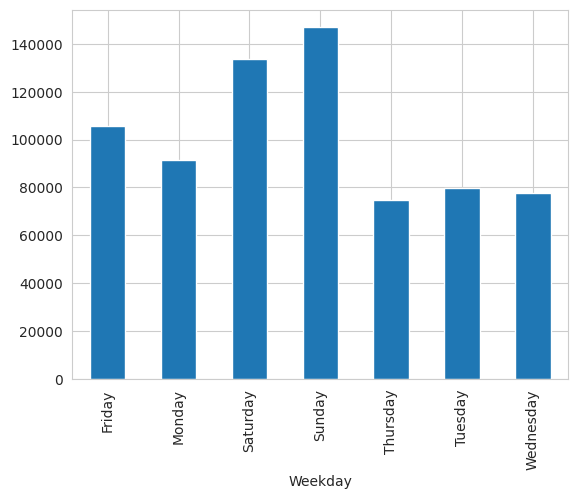

In [ ]:
df.groupby(['Weekday'])['ScanCount'].sum().plot.bar()

Look like Sunday, Saturday, and Friday generate the most sale

### Department Description

There are 68 department description

In [ ]:
len(df['DepartmentDescription'].unique())

68

Top ten department description sold

In [ ]:
df['DepartmentDescription'].value_counts().head(10)

,count
DepartmentDescription,
GROCERY DRY GOODS,69016
DSD GROCERY,66342
PRODUCE,49563
DAIRY,43006
PERSONAL CARE,41232
IMPULSE MERCHANDISE,27791
HOUSEHOLD CHEMICALS/SUPP,24352
PHARMACY OTC,22772
FROZEN FOODS,20726


Bottom ten department description sold

In [ ]:
df['DepartmentDescription'].value_counts().tail(10)

,count
DepartmentDescription,
1-HR PHOTO,337
MENSWEAR,302
CAMERAS AND SUPPLIES,207
PHARMACY RX,143
OPTICAL - LENSES,85
LARGE HOUSEHOLD GOODS,77
CONCEPT STORES,35
OTHER DEPARTMENTS,29
SEASONAL,29


<ipython-input-37-0cd7c3c5243c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sn.countplot(y='DepartmentDescription', data=df, palette='mako', order=df['DepartmentDescription'].value_counts().index)


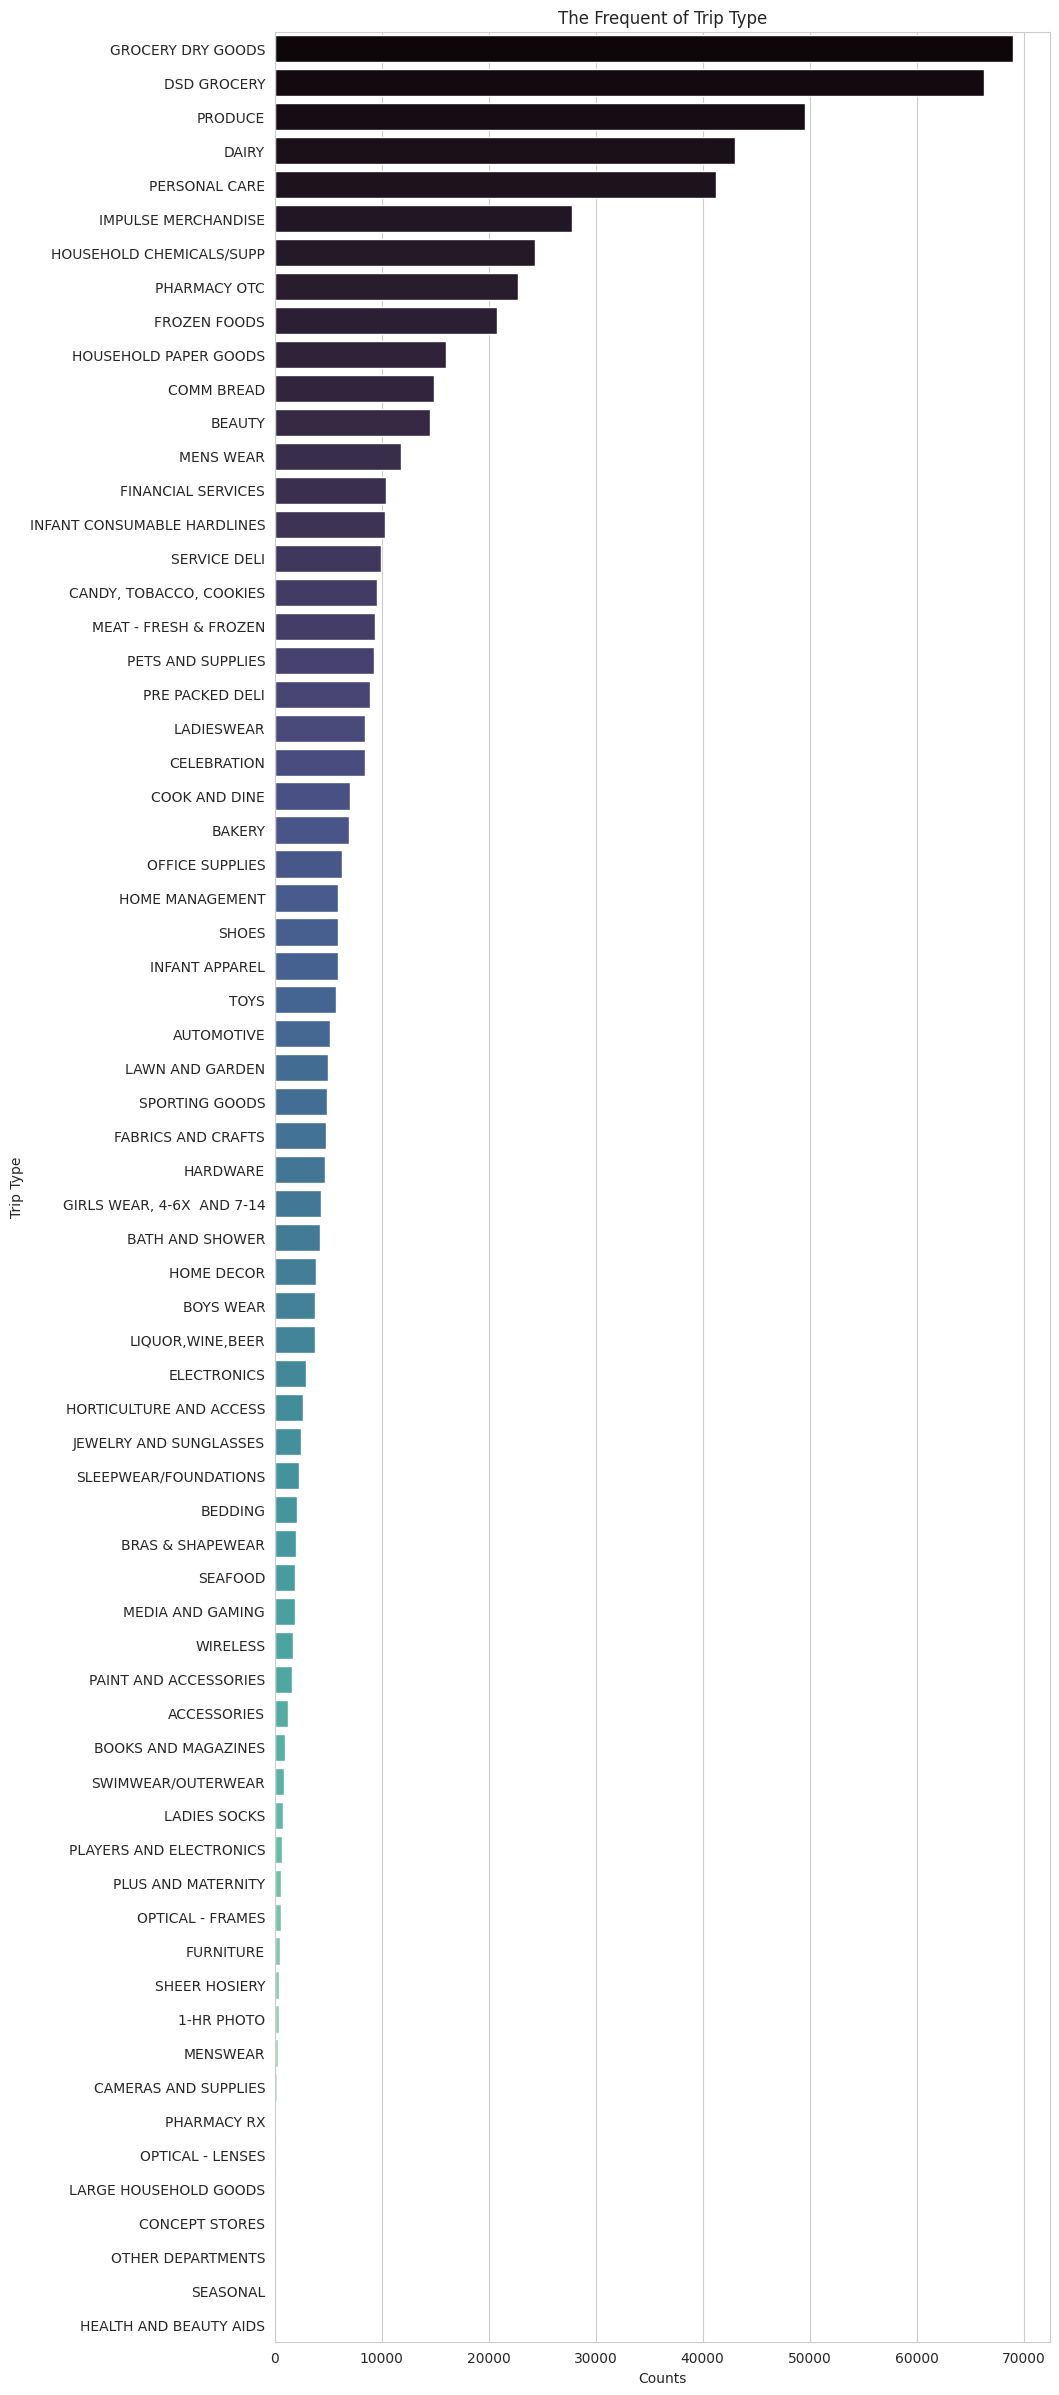

In [ ]:
plt.figure(figsize = (10, 30))

sn.set_style('whitegrid')
ax = sn.countplot(y='DepartmentDescription', data=df, palette='mako', order=df['DepartmentDescription'].value_counts().index)
sx = ax.set(title='The Frequent of Trip Type', xlabel='Counts', ylabel='Trip Type')

Produce and merchandise dominate the chart

### FinelineNumber

In [ ]:
len(df['FinelineNumber'].unique())

5188

In [ ]:
df['FinelineNumber'].value_counts()

,count
FinelineNumber,
5501.0,8150
1508.0,4904
135.0,4440
808.0,4331
0.0,3725
...,...
7838.0,1
3611.0,1
830.0,1


In [ ]:
df.groupby(['DepartmentDescription', 'FinelineNumber'])['ScanCount']\
.sum().reset_index().sort_values(by='ScanCount', ascending=False).head(10)

,DepartmentDescription,FinelineNumber,ScanCount
8666,PRODUCE,5501.0,8098
1859,DAIRY,1508.0,5623
4740,IMPULSE MERCHANDISE,808.0,4703
4713,IMPULSE MERCHANDISE,135.0,4634
2775,FINANCIAL SERVICES,0.0,3717
3339,GROCERY DRY GOODS,3120.0,3710
2113,DSD GROCERY,4606.0,3617
2250,DSD GROCERY,9546.0,3173
1839,DAIRY,1407.0,2947
4711,IMPULSE MERCHANDISE,115.0,2837


Again produce and merchandise dominate the chart

Fineline number is too granular, I will leave it out for now

# Feature Engineering

we need to change data into machine learning ready form. First we need 1 trip per row, luckily we already did that.

In [ ]:
X = number_item_purchase.copy()

In [ ]:
X.head()

,VisitNumber,unique_count,item_sum,TripType,Weekday
0,5,1,-1,999,Friday
1,7,2,2,30,Friday
2,8,20,27,26,Friday
3,9,3,3,8,Friday
4,10,3,3,8,Friday


## Create feature from department detail

Now let's add each department detail scan count as a predictors

In [ ]:
cat = df.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].sum().reset_index()
cat.head()

,VisitNumber,DepartmentDescription,ScanCount
0,5,FINANCIAL SERVICES,-1
1,7,PERSONAL CARE,1
2,7,SHOES,1
3,8,DAIRY,2
4,8,DSD GROCERY,1


In [ ]:
cat_sale = pd.pivot_table(cat, values=['ScanCount'], index=['VisitNumber'],
               columns=['DepartmentDescription'], aggfunc='sum')\
               .reset_index().fillna(0)
cat_sale.columns = cat_sale.columns.droplevel()
cat_sale = cat_sale.rename(columns={'': "VisitNumber"})
cat_sale.head()

DepartmentDescription,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = X.merge(cat_sale, on='VisitNumber')
X.head()

,VisitNumber,unique_count,item_sum,TripType,Weekday,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,5,1,-1,999,Friday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,2,2,30,Friday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,8,20,27,26,Friday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,3,3,8,Friday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,3,3,8,Friday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Encoding days

Change week day to numeric variable first

In [ ]:
day_of_week = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

In [ ]:
day = X['Weekday'].map(day_of_week)

Change numeric days to sin and cos to make it cyclical

In [ ]:
X['sin_day'] = np.sin(2*np.pi*day/7)
X['cos_day'] = np.cos(2*np.pi*day/7)
X = X.drop(['Weekday'], axis=1)

In [ ]:
X.head()

,VisitNumber,unique_count,item_sum,TripType,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,sin_day,cos_day
0,5,1,-1,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.433884,-0.900969
1,7,2,2,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.433884,-0.900969
2,8,20,27,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.433884,-0.900969
3,9,3,3,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.433884,-0.900969
4,10,3,3,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.433884,-0.900969


## Dealing with response

Setting y to be equal to Trip type

In [ ]:
data = X.copy()
y = X['TripType']
X = X.drop(['TripType', 'VisitNumber'], axis=1)

In [ ]:
y

,TripType
0,999
1,30
2,26
3,8
4,8
...,...
93081,25
93082,22
93083,39
93084,39


Before trying to classify the model let's have a last detail look at a Relationship between predictors and response

# Modelling

From the last EDA it seem trip type may be a lot more clear cut the expected. As the model try to estimate human judgement, the non-linear tree-based model may be a better fit.

## Split test set for use as final evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# 創建隨機森林分類器
rfc = RandomForestClassifier(n_estimators=500, random_state=42)

# 使用訓練資料訓練隨機森林分類器
rfc.fit(X_train, y_train)

# 預測測試資料的概率和分類結果
y_test_pred_prob = rfc.predict_proba(X_test)
y_test_pred = rfc.predict(X_test)

# 計算 log loss
log_loss_value = log_loss(y_test, y_test_pred_prob)
print('Log Loss:', log_loss_value)

# 確認模型是否訓練成功
pred_y = rfc.predict(X_train)

# 計算準確度
acc = accuracy_score(y_train, pred_y)

# 輸出準確度
print('Accuracy:', acc)


Log Loss: 1.3368782753346644
Accuracy: 0.928882204436805


### Other metrices

In [ ]:
report = metrics.classification_report(y_train, pred_y, digits=3, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
3,0.800837,0.983893,0.882977,2918.000000
4,0.967033,0.320000,0.480874,275.000000
5,0.853001,0.944735,0.896527,2678.000000
6,0.885090,0.915521,0.900048,1018.000000
7,0.938766,0.915129,0.926797,4607.000000
8,0.855142,0.928212,0.890180,9737.000000
9,0.828263,0.904447,0.864680,7556.000000
12,0.968037,0.954955,0.961451,222.000000
14,1.000000,1.000000,1.000000,3.000000
15,0.995804,0.912821,0.952508,780.000000


Unsurprisingly, Random Forest work better than the baseline model.

for multiclass classification, the model does better than expected; however, the model seem to has trouble classifying minority class

### features importance

<ipython-input-55-ce0dcabacfc8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sn.barplot( x='importance', y='features', data=importances, palette = 'mako')


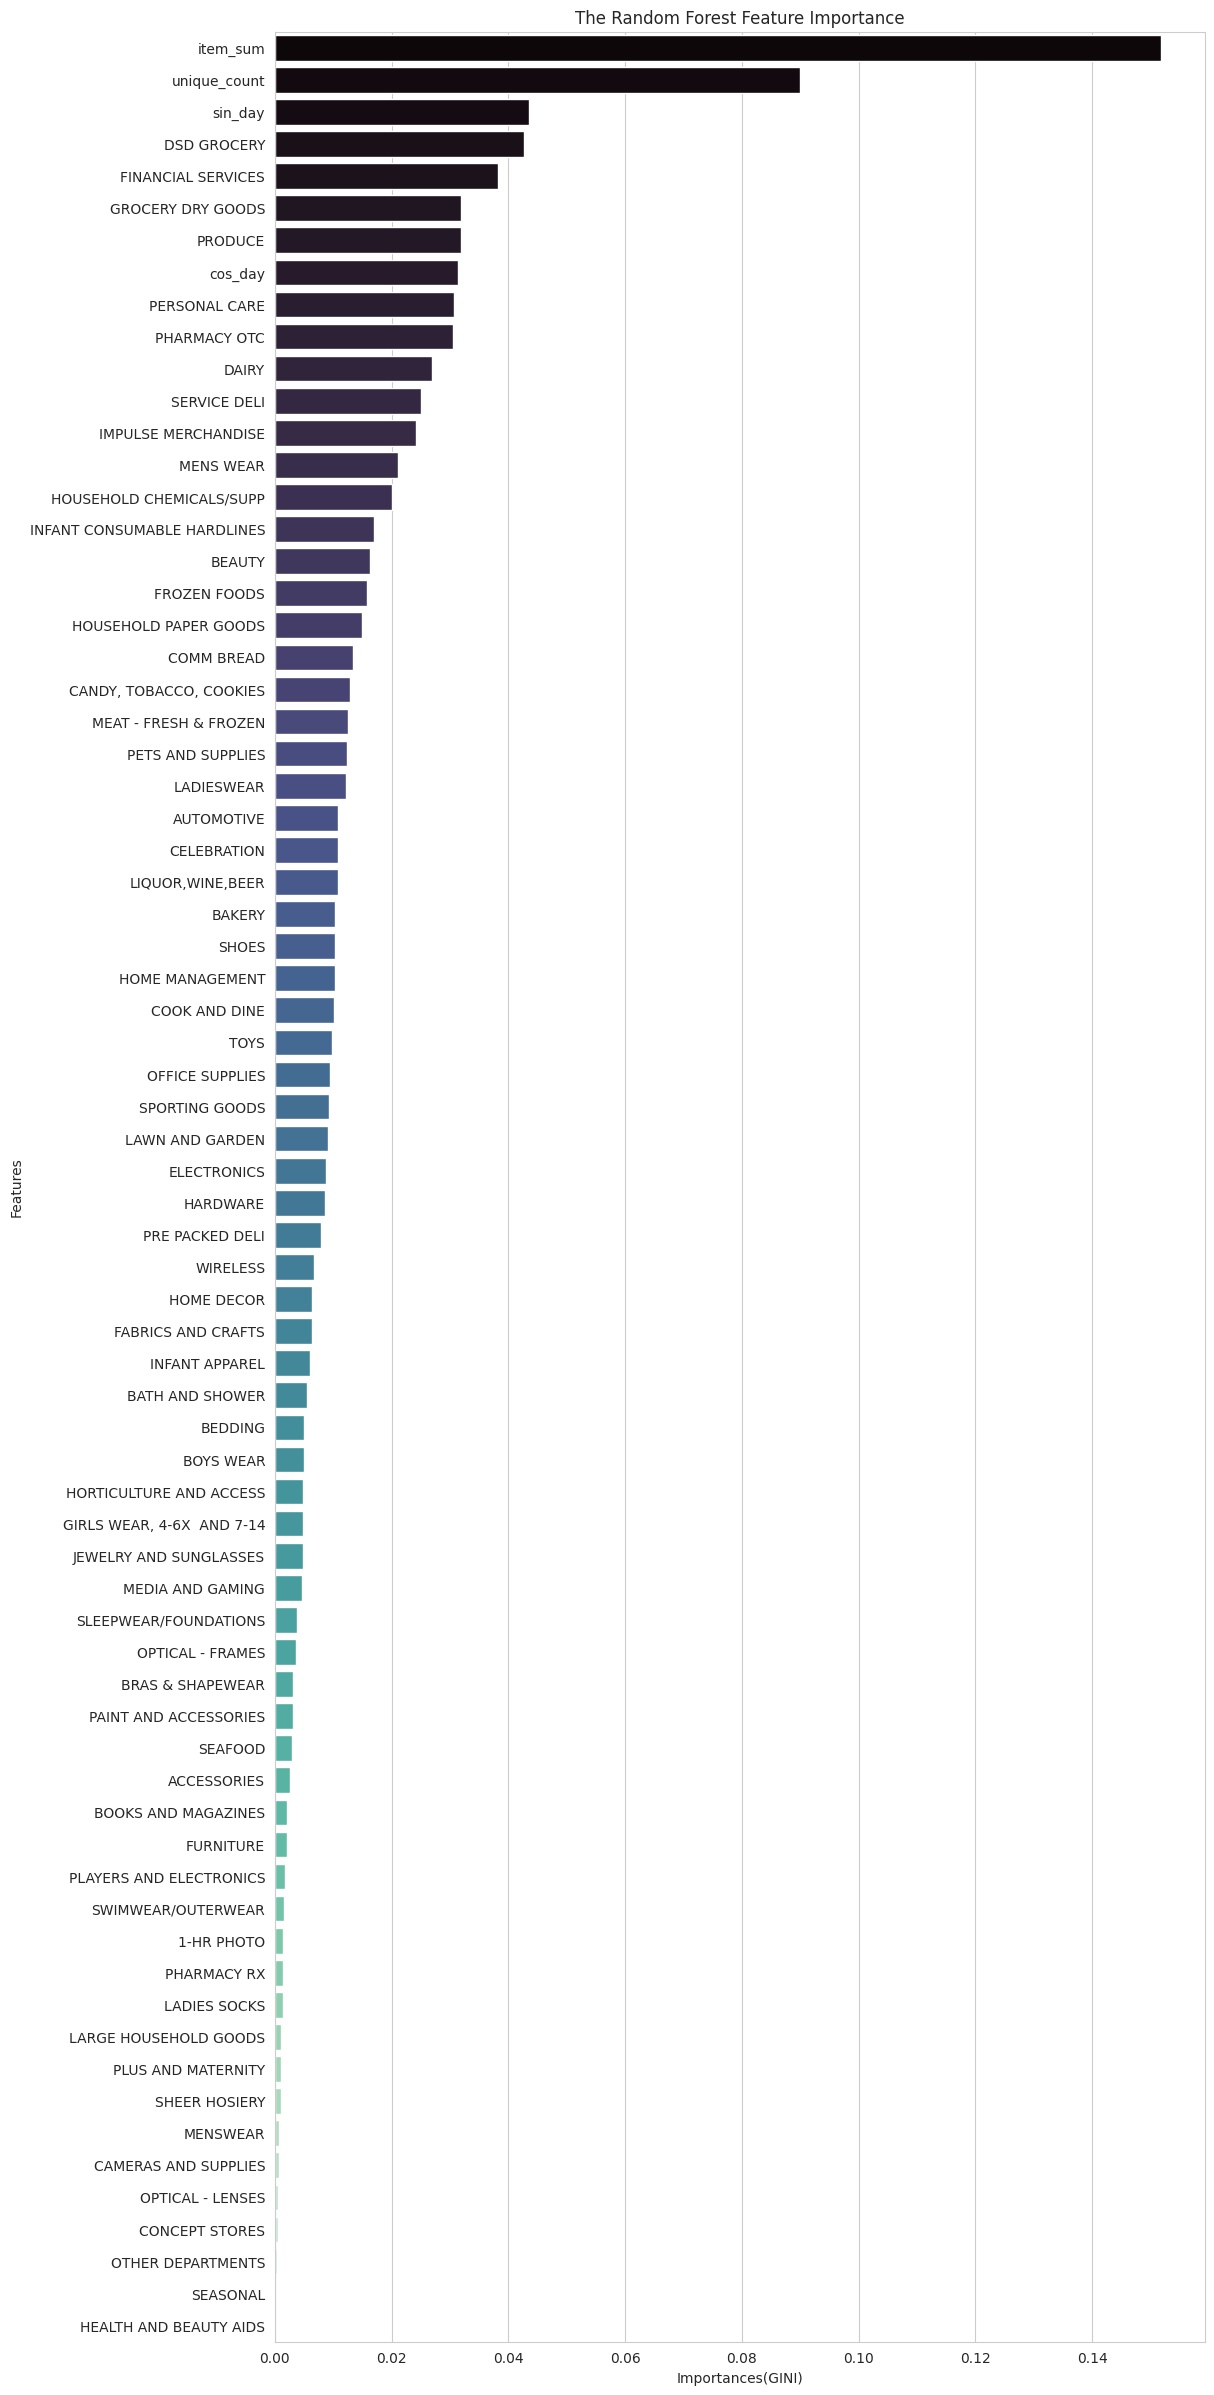

In [ ]:
importances = pd.DataFrame(rfc.feature_importances_, index=X_train.columns).reset_index()
importances.columns=['features', 'importance']
importances = importances.sort_values(by='importance', ascending=False)
plt.figure(figsize = (12, 30))
sn.set_style('whitegrid')
ax = sn.barplot( x='importance', y='features', data=importances, palette = 'mako')
ax = ax.set(title = 'The Random Forest Feature Importance', xlabel = 'Importances(GINI)', ylabel = 'Features')

The model seems to learn from total item purchase and unique item purchase well; the more popular the department, the more critical the feature.